**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

c) In neural networks, how does the ReLU function help us to generalize to conplex feature spaces? Why we are not using linear layers only? <br>

d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

## Answers ##

a) We don't necessarily need to output the actual probability values when performing classification with the softmax layer. Instead, we can use the output of the softmax layer to make a prediction about which class the input belongs to by selecting the class with the highest probability. The softmax layer's output values should be in the range of 0 to 1, as these values represent probabilities. However, the output values do not have to be within a specific range in order to be classified. The relative values of the output probabilities, rather than the specific values themselves, are important for classification.

b) Overfitting the data may occur if the model is too specific for the task. However, if the model is overly simple for the task, it may underfit the data.  
  
In CNN, especially around 30 epochs,OR after 40 epochs in FCN plot, it can be seen that training accuracy is increasing while validation accuracy is not increasing. Overfitting can be occur if the accuracy on the training dataset increases while the accuracy on the validation dataset decreases. Therefore, this kind of situation can be interpreted as overfitting.  
   
There was no example can be given from this assignment for underfitting but underfitting occurs if the accuracy on both the training and validation datasets is low and does not improve over the course of training. Something occasion like this can be a sign of underfitting.

c) The ReLU function has several advantages over linear activation functions. One of the main advantages is that it helps the model to learn complex feature spaces. This is because the ReLU function introduces non-linearity into the model, which allows it to capture more complex patterns in the data. This is particularly useful in deep neural networks, where multiple layers of non-linear activation functions can learn increasingly complex features.

On the other hand, linear activation functions are unable to capture complex feature spaces because they only perform a linear transformation on the input data. This means that linear activation functions are limited in their ability to model non-linear relationships in the data.

Overall, the use of non-linear activation functions such as the ReLU function is important for achieving good performance in many machine learning tasks, especially when dealing with complex datasets.

d) the number of learnable parameters is equal to the number of filters multiplied by the number of elements in the kernel, plus one bias term for each filter. In this case, the input feature map has dimensions 64x64x5, which means that it has 64 rows, 64 columns, and 5 channels. The convolutional layer will operate on each channel independently, so it will have the same number of learnable parameters for each channel. This means that the total number of learnable parameters in the convolutional layer is 54 * 5 = 270.

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [1]:
import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [2]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: NVIDIA GeForce RTX 2060
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     6.0 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [3]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, **kwargs):
        # Save the data and labels as members of the class
        self.data = data
        self.labels = labels

        # Save any additional keyword arguments as members of the class
        self.kwargs = kwargs

    def __len__(self):
        # Return the length of the dataset
        return len(self.data)

    def __getitem__(self, index):
        # Return the data and label for the given index
        return self.data[index], self.labels[index]


In [5]:
import torchvision.transforms as transforms
dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])

In [6]:
from torchvision.datasets import ImageFolder

# Create the dataset object
root_directory = "./Multi-class Weather Dataset" # Current directory
dataset = ImageFolder(root=root_directory, transform=dataset_transform)

# Print the class names
print(dataset.classes)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [7]:
from torch.utils.data.dataset import random_split
# Calculate the size of each split
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Create the splits
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [8]:
train_set,val_set,test_set

(<torch.utils.data.dataset.Subset at 0x228faf16820>,
 <torch.utils.data.dataset.Subset at 0x228faf167f0>)

In [9]:
train_batch, val_batch, test_batch = 64, 64, 64

## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [10]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, **kwargs):
        super(ConvNet, self).__init__()      
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc=nn.Linear(128*28*28, 4)
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        x=x.reshape(-1, 128*28*28)
        x=self.fc(x)
        return x

### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [11]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, **kwargs):
        super(FCNet, self).__init__()      
        self.fc1=nn.Linear(224*224*3, 1024)
        self.fc2=nn.Linear(1024, 512)
        self.fc3=nn.Linear(512, 256)
        self.fc4=nn.Linear(256, 4)

     
    def forward(self, x):
        x=x.view(-1,224*224*3)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return x

## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

### Training [12 points]

In [76]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 80
train_batch = 32
test_batch = 64
learning_rate = 1e-2
momentum = 0.5
weight_decay = 5e-04

# TODO: training loop + eval

In [19]:
import tqdm # I imported this library to see better visualization in the training process
# This library is only use for visusalization
# It has no affect to algorithm

In [20]:
def inference (model, val_set, val_batch):
    # passing model to device to use GPU
    model = model.to(device)
    # Loading the data
    val_loader = DataLoader(val_set, batch_size=val_batch, shuffle=True)
    # Defining loss function(criterion)
    criterion = nn.CrossEntropyLoss()
    
    true_prediction = 0
    total_predictions = 0
    running_loss = 0
    
    # Disabling gradient updates for inference process
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            # Get the input features and target labels, and put them on the GPU
            inputs=images.to(device)
            labels = labels.to(device)
            # Get predictions
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            true_prediction += (prediction == labels).sum().item()
            total_predictions += prediction.shape[0]

        batch_number = len(val_loader)
        avg_loss = running_loss / batch_number
        accuracy = true_prediction/total_predictions
        #print(f'Accuracy: {accuracy:.2f}, Total items: {total_predictions}')
        return avg_loss, accuracy

In [21]:
def train(model,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate,momentum,weight_decay):
    # passing model to device to use GPU
    model = model.to(device) 
    # Loading the data
    train_loader = DataLoader(train_set, batch_size=train_batch, shuffle=True)
    # Defining loss function(criterion) and optimizer with parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    # Creating lists to store data from the training process
    Train_loss_list = []
    Val_loss_list = []
    Train_acc_list = []
    Val_acc_list = []
    n = len(train_loader)
    
    for epoch in range(max_epoch):
        true_prediction = 0
        total_predictions = 0  
        running_loss=0
        with tqdm.tqdm(total= n, desc=f"Epoch {epoch+1}") as pbar:
            for i, (images, labels) in enumerate(train_loader):
                # passing inputs to device to use GPU
                images = images.to(device)
                labels = labels.to(device)     

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())
                running_loss += loss.item()
                
                # Get the predicted class with the highest score
                _, prediction = torch.max(outputs,1) # no need for first return
                # Count of predictions that matched the target label
                true_prediction += (prediction == labels).sum().item()
                total_predictions += prediction.shape[0]
        batch_number = len(train_loader)
        avg_loss = running_loss / batch_number
        train_acc = true_prediction/total_predictions
        val_loss, val_acc = inference(model, val_set, val_batch)    
        Train_loss_list.append(avg_loss)
        Val_loss_list.append(val_loss)
        Val_acc_list.append(val_acc)
        Train_acc_list.append(train_acc)
    return Train_loss_list, Val_loss_list, Val_acc_list, Train_acc_list

In [77]:
model = FCNet()

## Analysis about hyperparameters ##
-Changing learning rate 0.05 to 0.01 changes test accuracy by 0.74 to 0.83 (even though the results change every time trying because of the randomness, decreasing value to 0.01 absolutely increases the accuracy)  
-Changing batch sizes increases model speed, it is more related to the ram and memory parts.  
-Changing momentum from 0.5 to 0.9 it gets less accuracy while having same epoch number, also, even in the peak values it is less than the value while momentum = 0.5  
-Changing momentum from 0.5 to 0.1 it gets similar accuracy rates while having 35 epochs (lower than before), in the figures I saw learning curve of training curve is going to high without saturating but validation curve is not changing that means it gets overfitted. Therefore, I decided not to change momentum  
-Weight decay is using for regularization, mostly used for preventing overfitting. Changing values of weight decay does not effect result much, therefore, I did not change it. 

Finally I found these values as optimal for the model:  
max_epoch = 80  
train_batch = 32  
test_batch = 64  
learning_rate = 1e-2  
momentum = 0.5  
weight_decay = 5e-04  

**Note That:** I used these hyperparameters for all models. Also, It can be seen in the figures that epoch number can be less than 80 to reach peak performance, but I wanted to show the change in a larger scale

In [78]:
Train_loss_list, Val_loss_list, Val_acc_list, Train_acc_list = train(model,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate,momentum,weight_decay)

Epoch 68: 100%|███████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.09it/s, loss=0.0593]


Epoch 80: 100%|███████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.04it/s, loss=0.0184]


### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

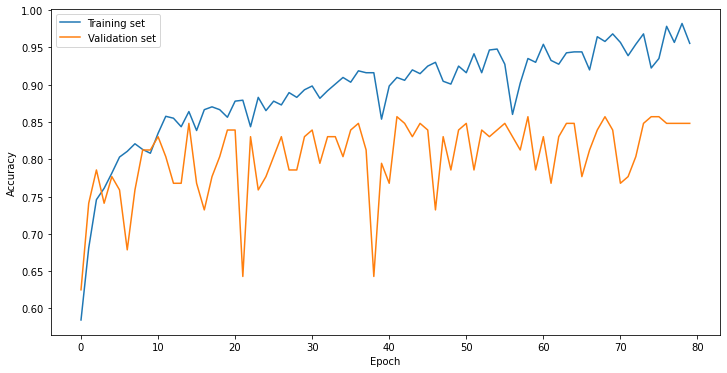

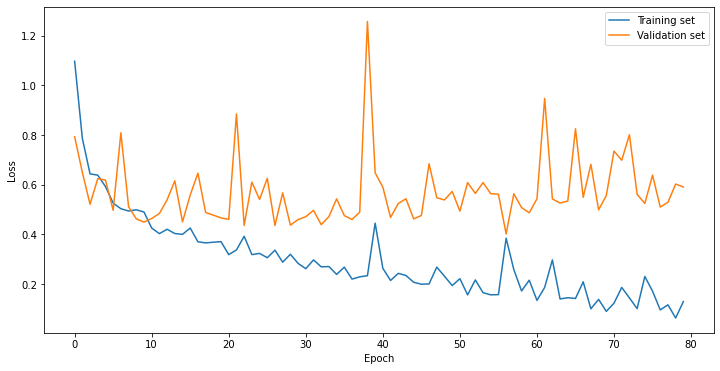

In [79]:
def plot(train_param, val_param, metric):
    plt.figure(figsize = (12,6))
    plt.plot(train_param, label="Training set")
    plt.plot(val_param, label="Validation set")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.show()
metric = "Accuracy"
plot(Train_acc_list, Val_acc_list, metric)
metric = "Loss"
plot(Train_loss_list, Val_loss_list, metric)

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

In [47]:
def test(model,test_set):
    # passing model to device to use CPU
    model = model.to('cpu') 
    
    # Loading the data
    test_loader = DataLoader(test_set, batch_size=test_batch, shuffle=True)
    # Defining loss function(criterion) and optimizer with parameters
    criterion = nn.CrossEntropyLoss()

    correct_prediction = 0
    total_prediction = 0
    running_loss = 0
    
    # Creating lists to store data from the training process
    cm_list=[]
    f_score_list=[]
    p_score_list=[]
    r_score_list=[]
    test_acc_list=[]
    
    # Disable gradient updates
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            #print(len(test_loader))
            # Get the input features and target labels, and put them on the GPU
            inputs=images.to('cpu')
            labels = labels.to('cpu')
            #print(inputs,inputs.size())
            #y_tests.append(inputs)
            # Get predictions
            model = model.to('cpu')
            outputs = model(inputs).to('cpu')

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)

            #y_pred.append(prediction)

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            f1 = f1_score(labels, prediction, average='macro')
            precision=precision_score(labels, prediction, average='macro')
            recall=recall_score(labels, prediction, average='macro')
            cm = confusion_matrix(labels,prediction)
            accuracy = correct_prediction/total_prediction

            cm_list.append(cm)
            f_score_list.append(f1)
            p_score_list.append(precision)
            r_score_list.append(recall)
            test_acc_list.append(accuracy)
    return test_acc_list, f_score_list, p_score_list, r_score_list, cm_list

In [48]:
def report_test(test_acc_list, f_score_list, p_score_list, r_score_list, cm_list):
    print(f"Test accuracy is {sum(test_acc_list)/len(test_acc_list)}") # Note that these are average scores
    print(f"F score is {sum(f_score_list)/len(f_score_list)}")
    print(f"Precision is {sum(p_score_list)/len(p_score_list)}")
    print(f"Recall is {sum(r_score_list)/len(r_score_list)}")
    print(f"Confusion matrix is below \n {sum(cm_list)}")


In [87]:
test_acc_list, f_score_list, p_score_list, r_score_list, cm_list = test(model,test_set)
report_test(test_acc_list, f_score_list, p_score_list, r_score_list, cm_list)

Test accuracy is 0.8300377949852507
F score is 0.7881193823049641
Precision is 0.8200233177415082
Recall is 0.7870127808208303
Confusion matrix is below 
 [[33  3 14  0]
 [12 29  5  1]
 [ 4  0 53  1]
 [ 1  0  2 68]]


In [81]:
def save_model(model, filepath): # saving the evaluated model
    # Save the model to a file
    torch.save(model, filepath)
    # Save the model's weights and biases
    torch.save(model.state_dict(), filepath + '_weights.pt')

In [82]:
def load_model(filepath): # loading the model if necessary
    # Load the saved model
    model = torch.load(filepath)
    # Load the saved weights and biases
    model.load_state_dict(torch.load(filepath + '_weights.pt'))
    return model

In [88]:
save_model(model, "./best_model_fcn")

## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [89]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 80
train_batch = 32
test_batch = 64
learning_rate = 1e-2
momentum = 0.5
weight_decay = 5e-04

# TODO: training loop + eval

In [90]:
model_2 = ConvNet()
model_2

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=100352, out_features=4, bias=True)
)

In [91]:
Train_loss_list_2, Val_loss_list_2, Val_acc_list_2, Train_acc_list_2 = train(model_2,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate,momentum,weight_decay)

Epoch 68: 100%|███████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.71it/s, loss=0.0165]


Epoch 80: 100%|██████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.74it/s, loss=0.00647]


### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

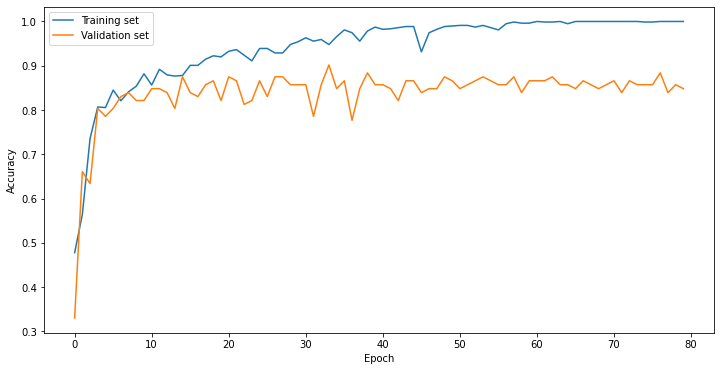

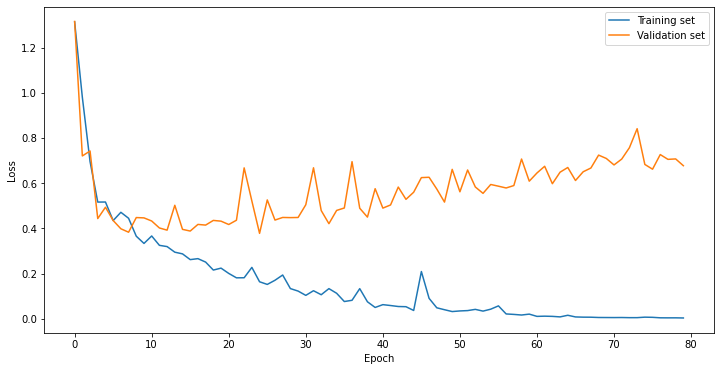

In [92]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
metric = "Accuracy"
plot(Train_acc_list_2,Val_acc_list_2,metric)
metric = "Loss"
plot(Train_loss_list_2,Val_loss_list_2,metric)

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

In [96]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
test_acc_list_2, f_score_list_2, p_score_list_2, r_score_list_2, cm_list_2 = test(model_2,test_set)
report_test(test_acc_list_2, f_score_list_2, p_score_list_2, r_score_list_2, cm_list_2)

Test accuracy is 0.8968242994100295
F score is 0.863439346662225
Precision is 0.8787395337970996
Recall is 0.8660867294792411
Confusion matrix is below 
 [[34  7  9  0]
 [ 3 42  2  0]
 [ 0  3 54  1]
 [ 0  0  0 71]]


In [97]:
save_model(model_2, "./best_model_cnn")

### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

## Answer ##
After hypertuning both models, I get test accuracy results as approximately 0.9 and 0.83 for cnn and fcn, respectively. Therefore, the results of cnn is higher than fcn model. In addition, as fcn includes less parameters than cnn it is faster to train fcn.  

CNN RESULTS:  
Test accuracy is 0.8968242994100295  
F score is 0.863439346662225  
Precision is 0.8787395337970996  
Recall is 0.8660867294792411  

FCN RESULTS:  
Test accuracy is 0.8300377949852507  
F score is 0.7881193823049641  
Precision is 0.8200233177415082  
Recall is 0.7870127808208303  

Type Markdown and LaTeX:  𝛼2

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

In [98]:
# Defining the pre-trained model
model_3=models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
features=model_3.fc.in_features
# Adding linear layer
model_3.fc=nn.Linear(features,4)


In [99]:
model_3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

###Training [12 points]

In [100]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 80
train_batch = 32
test_batch = 64
learning_rate = 1e-2
weight_decay = 5e-04

# TODO: Implement training loop + eval using ResNet-18 model


In [101]:
model = model_3 # from the above cell getting the pretrained model with another output layer
Train_loss_list_3, Val_loss_list_3, Val_acc_list_3, Train_acc_list_3 = train(model,train_set,val_set,max_epoch,train_batch,val_batch,learning_rate,momentum,weight_decay)

Epoch 68: 100%|█████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.15it/s, loss=0.000154]


Epoch 80: 100%|████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.14it/s, loss=0.014]


###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

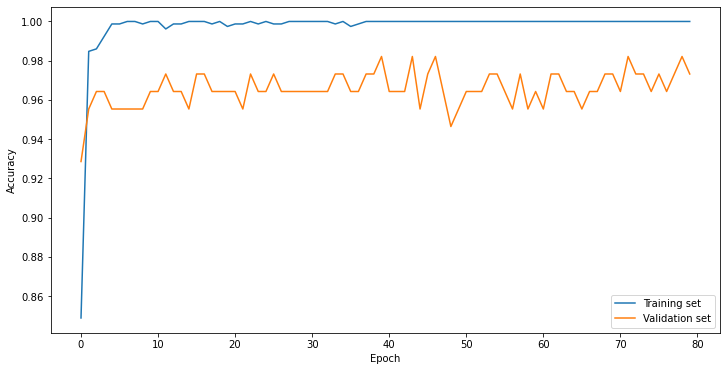

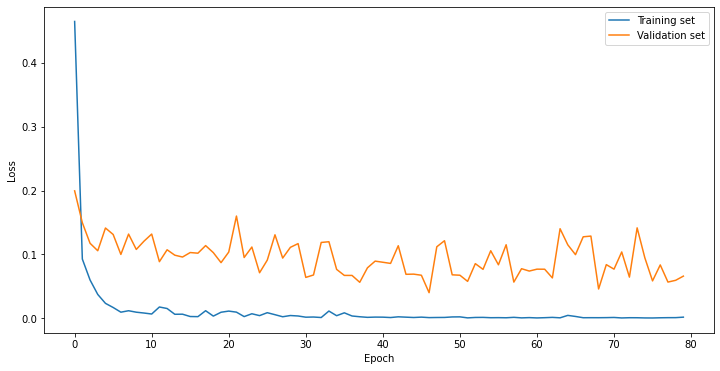

In [102]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
metric = "Accuracy"
plot(Train_acc_list_3,Val_acc_list_3,metric)
metric = "Loss"
plot(Train_loss_list_3,Val_loss_list_3,metric)

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

In [107]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
test_acc_list_3, f_score_list_3, p_score_list_3, r_score_list_3, cm_list_3 = test(model_3,test_set)
report_test(test_acc_list_3, f_score_list_3, p_score_list_3, r_score_list_3, cm_list_3)

Test accuracy is 0.9600963311209441
F score is 0.9598523843987554
Precision is 0.9579342532467533
Recall is 0.9633037968975469
Confusion matrix is below 
 [[46  0  4  0]
 [ 1 46  0  0]
 [ 2  1 54  1]
 [ 0  0  0 71]]


In [108]:
save_model(model_3,"./best_model_transfered")

### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

## Answer ##
As it can be seen from the performances of test accuracy and others. The best performance metrics are in the third model which includes transfer learning. Thus, transfer learning does improve the performance. It improves performance because it uses a pre trained larger model. Using pre trained large model and changing its output layer mostly gives better performances than the basic models that have fewer layers. These models gives better performance metrics with lower number of epochs as it can be seen in the plot in that section, it reaches peak at the very beginning of the epochs

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1